In [ ]:
!pip install adversarial-robustness-toolbox

In [2]:
!pip install git+https://github.com/nottombrown/imagenet_stubs --upgrade

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-y_ax4e91
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-y_ax4e91
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794840 sha256=fa8d8c44e31363343158e3e187fcccbd170d90c43417740f19f7500593837ce1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ual52e_s/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


In [3]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch
from art.attacks.evasion import AdversarialPatchPyTorch

In [4]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.1
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5.
max_iter = 500

Model

In [5]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values)

102973440/102967424 [==============================] - 1s 0us/step


In [6]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    #im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [7]:
#keras Tutorial: Using a pre-trained ImageNet
import numpy as np
# import the models for further classification experiments
from tensorflow.keras.applications import (
        vgg16,
        resnet50,
        mobilenet,
        inception_v3
    )
resnet_model = resnet50.ResNet50(weights='imagenet')
image_batch = np.expand_dims(images, axis=0)
#processed_images=image_batch
processed_images = resnet50.preprocess_input(image_batch.copy())

In [8]:
tfc.predict(processed_images[0])

array([[3.29909184e-08, 1.19618420e-07, 9.19542487e-08, ...,
        7.29186695e-07, 1.29007287e-06, 1.03046744e-07],
       [2.39431125e-14, 2.87392994e-14, 3.46812931e-14, ...,
        2.43357903e-11, 3.42823492e-10, 8.77717929e-13],
       [5.49429981e-11, 6.32253408e-12, 6.13435136e-11, ...,
        6.01861755e-11, 1.33233389e-08, 2.43864484e-10],
       ...,
       [1.43743391e-08, 9.64000222e-08, 1.09610419e-08, ...,
        3.13790616e-09, 9.78539632e-08, 1.27734199e-06],
       [7.06720127e-10, 3.47562046e-09, 9.94275107e-10, ...,
        1.34859635e-09, 1.86289473e-08, 1.67413585e-08],
       [5.09454590e-10, 4.85675215e-11, 6.99695232e-11, ...,
        8.39478972e-11, 2.19165935e-10, 2.63022187e-10]], dtype=float32)

ImageNet Training

In [9]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

In [10]:
predictions = tfc.predict(processed_images[0])
label = decode_predictions(predictions)
# print VGG16 predictions
for prediction_id in range(len(label[0])):
    print(label[0][prediction_id])

40960/35363 [==================================] - 0s 0us/step
('n01882714', 'koala', 0.9985916)
('n02500267', 'indri', 0.00056702015)
('n02356798', 'fox_squirrel', 0.00011986389)
('n02497673', 'Madagascar_cat', 9.8401775e-05)
('n01883070', 'wombat', 6.5779794e-05)


In [11]:
processed_images=processed_images.reshape(16, 224, 224, 3)

Patch_gen

In [14]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224,3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))
patch, patch_mask = ap.generate(x=processed_images, y=y_target)


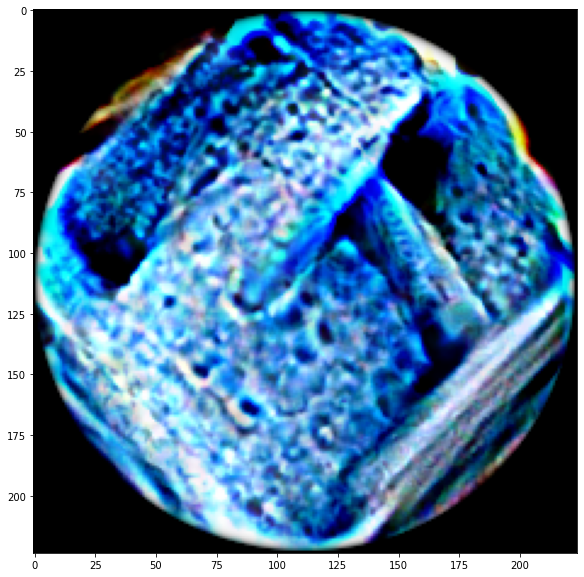

In [14]:
#Adversarial Patch
plt.imshow(((patch) * patch_mask).astype(np.uint8))

In [15]:
patched_images = ap.apply_patch(images, scale=.3)

In [13]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 8.1MB/s 


In [16]:
def predict_model(classifier, image):
    plt.imshow((image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    #print("error1")
    prediction = classifier.predict(image)
    #print("error2")
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

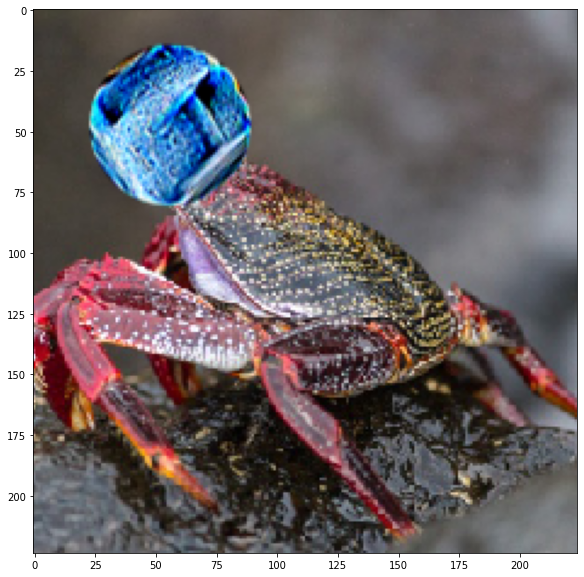

Predictions:
fiddler_crab 0.82
toaster      0.05
rock_crab    0.04
crayfish     0.04
agama        0.01


In [19]:
predict_model(tfc, patched_images[10])

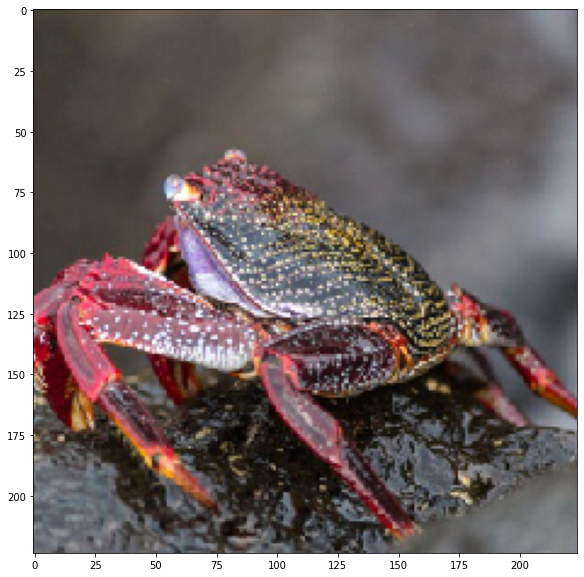

In [18]:
plt.imshow((images[10].astype(np.uint8)))

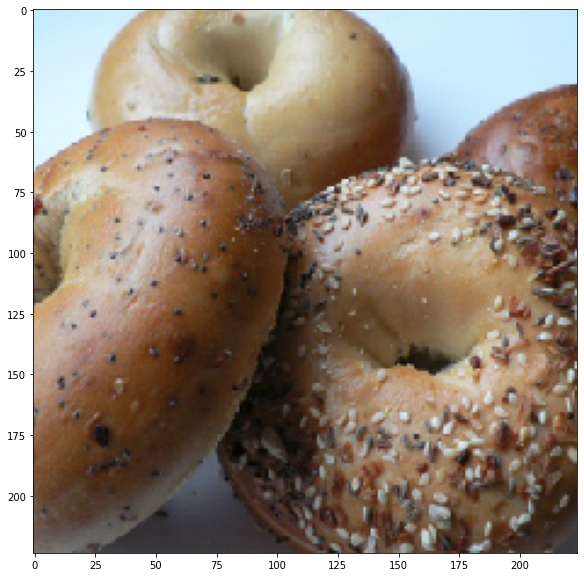

Predictions:
bagel      0.96
coil       0.01
knot       0.01
chain      0.00
strawberry 0.00


In [20]:
predict_model(tfc,images[2])

Image SuperPixel Segmentation

In [21]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
type(patched_images[6])

numpy.ndarray

In [ ]:
# load the image and convert it to a floating point data type
image = img_as_float(patched_images[6].astype(np.uint8))
fig = plt.figure()
for numSegments, i in ((50, 1), (100, 2)):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(image, n_segments = numSegments, sigma = 5)

	# show the output of SLIC
	ax = fig.add_subplot(3, 1, i)
	ax.set_title("Superpixels -- %d segments" % (numSegments))
	ax.imshow(mark_boundaries(image, segments))
	plt.axis("off")

# show the plots
plt.show()

In [22]:
def SLIC(im,numSegments):
  image = img_as_float(im.astype(np.uint8))
  fig = plt.figure()
  segments = slic(image, n_segments = numSegments, compactness=50,sigma = 5)
  plt.imshow(mark_boundaries(image, segments))
  plt.axis("off")
  plt.show()


In [23]:
def SLIC1(im,numSegments):
  image = img_as_float(im)
  fig = plt.figure()
  segments = slic(image, n_segments = numSegments, compactness=10,sigma = 5)
  plt.imshow(mark_boundaries(image, segments))
  plt.axis("off")
  plt.show()

In [ ]:
SLIC(patched_images[2],500)

In [30]:
from google.colab import files
uploaded = files.upload()

Saving sms6_0.jpg to sms6_0.jpg


In [35]:
ls

frc4_29.jpg  sample_data/  sms6_0.jpg


In [ ]:
from skimage import io
from PIL import Image
img1=Image.open('frc4_29.jpg')#io.imread('PA2.jpg')
img1 = img1.resize((600, 600))
plt.imshow(img1)
SLIC1(img1,1000)

Depth Algorithm